VectorLinearRegressionでwightが直交行列になるかをconditional numberを用いて観察する。

In [1]:
from __future__ import division

import time
import gzip

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

import TN_utils
reload(TN_utils)
plt.set_cmap("gray")
plt.rcParams["image.interpolation"] = None

In [2]:
import seaborn as sb
sb.set_style("whitegrid")

/Users/matsuik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
a = np.array([[3, -4],[4, 3]])
b = np.array([[- 3, 4],[4, 3]])
np.linalg.det(a), np.linalg.det(b)

(25.000000000000007, -25.000000000000007)

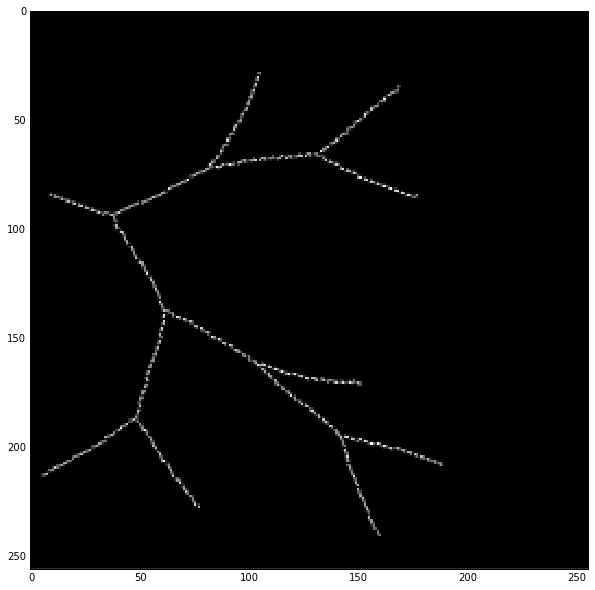

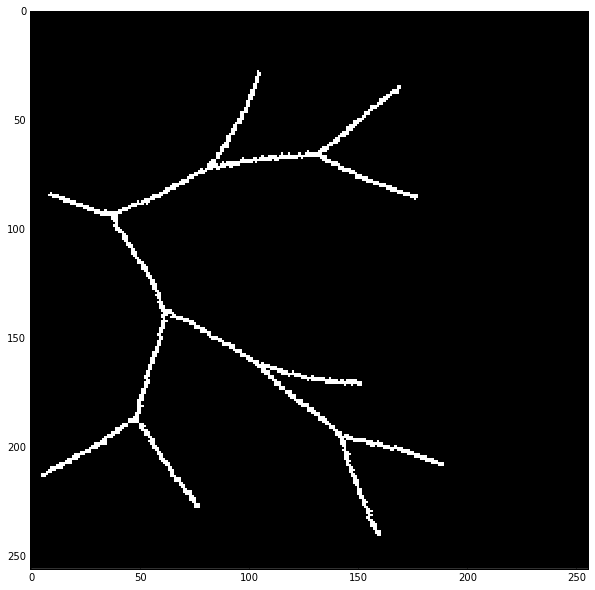

In [4]:
with gzip.open("../data/toytreerot_imgGT.npy.gz") as f:
    imGT_list = np.load(f)
imGT_list.shape
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.norm(imGT_list[6], axis=1).reshape(256, 256))
for i in range(len(imGT_list)):
    index = np.linalg.norm(imGT_list[i], axis=1).nonzero()[0]
    imGT_list[i][index] = imGT_list[i][index] / np.linalg.norm(imGT_list[i], axis=1)[index][:, np.newaxis]
plt.figure(figsize=(10, 10))
plt.imshow(np.linalg.norm(imGT_list[6], axis=1).reshape(256, 256))

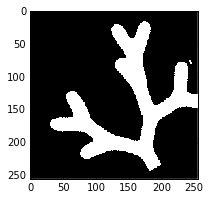

In [5]:
with gzip.open("../data/toytreerot_mask.npy.gz") as f:
    mask_list = np.load(f)
mask_list.shape
plt.figure(figsize=(3, 3))
plt.imshow(mask_list[20].reshape(256, 256))

In [6]:
featureImg_list = []
for i in range(1, 37):
    print i
    matlab_struct = sio.loadmat('../data/featureImgr' + str(i) + '.mat')
    featureImg = matlab_struct['f']

    # 複素数からベクトルへの変換
    featureImg_vec = np.zeros((featureImg.shape[0], 12, 2))
    featureImg_vec[:, :, 0] = np.real(featureImg[:, 12:24])
    featureImg_vec[:,:,1] = np.imag(featureImg[:, 12:24])
    featureImg_list.append(featureImg_vec)

print featureImg.dtype, featureImg_list[1].shape

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
complex128 (65536, 12, 2)


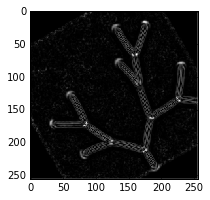

In [7]:
plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(featureImg_list[20][:, 5], axis=1).reshape(256, 256))

In [8]:
m_featureImg_list = [featureImg_list[i][mask_list[i]] for i in range(36)]
m_imgGT_list = [imGT_list[i][mask_list[i]] for i in range(36)]

In [9]:
m_feature_t1 = m_featureImg_list[0]
m_GT_t1 = m_imgGT_list[0]
m_feature_t1.shape, m_GT_t1.shape

((13857, 12, 2), (13857, 2))

In [10]:
range(0, 36, 4)

[0, 4, 8, 12, 16, 20, 24, 28, 32]

In [11]:

m_feature_t12 = np.concatenate([m_featureImg_list[i] for i in range(0, 36, 4)], axis=0)
m_GT_t12 = np.concatenate([m_imgGT_list[i] for i in range(0, 36, 4)], axis=0)
print m_feature_t12.shape, m_GT_t12.shape

(124755, 12, 2) (124755, 2)


In [12]:
m_feature_t36 = np.concatenate([m_featureImg_list[i] for i in range(0, 11) + range(12, 36)], axis=0)
m_GT_t36 = np.concatenate([m_imgGT_list[i] for i in range(0, 11) + range(12, 36)], axis=0)
print m_feature_t36.shape, m_GT_t36.shape

(485423, 12, 2) (485423, 2)


In [13]:
m_feature_vec120 = m_featureImg_list[11]
m_GT_vec120 = m_imgGT_list[11]

In [14]:
activation_list = ["ReLU"]
n_tensors = 12
dim = 2
param_list = [0.01 * np.random.normal(size=(n_tensors*dim, dim)), np.zeros(dim)]

In [15]:
import theano_dnn
reload(theano_dnn)

Couldn't import dot_parser, loading of dot files will not be possible.


<module 'theano_dnn' from 'theano_dnn.pyc'>

In [16]:
vnn = theano_dnn.VnnClf(m_feature_t1, m_GT_t1,
                         m_feature_vec120, m_GT_vec120,
                         param_list, ["w1", "b1", "w2", "b2"], activation_list,
                       vector_activation_shape_list=[2])

In [17]:
vnn.initialize_params(param_list)

In [19]:
vnn.set_training(feature_list[1], GT_list[1]) 

In [20]:
batch_size = 100
l2 = 0.

n_batchs = vnn.n_pixels // batch_size
        
n_epochs = epoch_list[1]
interval = n_epochs // 30
training_MSE_array = np.zeros(n_epochs // interval)
test_MSE_array = np.zeros(n_epochs // interval)

In [22]:
cn_list_list = []
det_list_list = []
weighted_sum_list = []
lr = lr_list[1]
for i_epoch in xrange(n_epochs):
    for i_batch in xrange(n_batchs):
        vnn.train(i_batch, lr, l2, batch_size)

    if i_epoch % interval == 0:
        MSE = vnn.training_error()
        training_MSE_array[i_epoch // interval] = MSE
        MSE = vnn.test_error()
        test_MSE_array[i_epoch // interval] = MSE

        w_list = vnn.get_w_list()
        cn_list = []
        det_list = []
        for aw in w_list:
            cn_list.append(TN_utils.clcl_cn_inv(aw))
            det_list.append(np.linalg.det(aw))  
        cn_list_list.append(cn_list)
        det_list_list.append(det_list)
        print i_epoch, MSE

0 0.018451345343
6 0.0141086315954
12 0.0139582561079
18 0.0139184961576
24 0.0138983924736
30 0.013885381352
36 0.0138759322328
42 0.0138686765576
48 0.0138629574099
54 0.0138583999012
60 0.0138547591954
66 0.0138518590698
72 0.0138495641779
78 0.0138477662879
84 0.0138463768084
90 0.0138453223231
96 0.0138445416471
102 0.0138439837034
108 0.0138436058789
114 0.0138433726905
120 0.0138432546717
126 0.0138432274319
132 0.0138432708543
138 0.0138433684135
144 0.0138435065936
150 0.0138436743943
156 0.013843862912
162 0.0138440649862
168 0.0138442749008
174 0.0138444881333


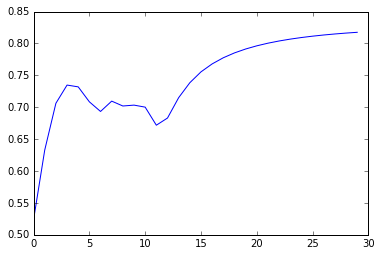

In [26]:
plt.plot(np.mean(np.asarray(cn_list_list), axis=1))

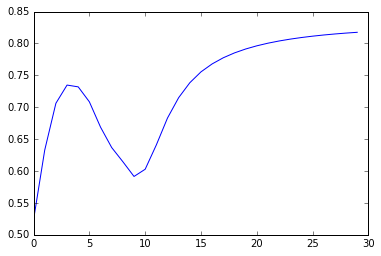

In [27]:
plt.plot(np.mean(np.asarray(cn_list_list) * np.sign(det_list_list), axis=1))

In [24]:
cn_list_list

[[0.51629984264217932,
  0.71442263398340733,
  0.55517538518749088,
  0.24136315224242688,
  0.015261451566719644,
  0.73517953306497508,
  0.95003512437187632,
  0.28222208653960384,
  0.93305520808586229,
  0.48153572894163127,
  0.68480475916714956,
  0.17498818849118519],
 [0.87812196899489414,
  0.86681026846643705,
  0.92391869308716568,
  3.489182166013752e-05,
  0.64624869497180248,
  0.87662976730450504,
  0.95143012251475578,
  0.12957895281670334,
  0.97069646950468869,
  0.42354164834744346,
  0.85441541060967152,
  0.073530827463493681],
 [0.91187158226446341,
  0.89161420169842687,
  0.87380319652899796,
  0.27199140755286144,
  0.78706418160434888,
  0.82223494283888676,
  0.95554768832640413,
  0.17258152487364734,
  0.97086360745609823,
  0.43114028880691641,
  0.88743359248378717,
  0.49888582158797956],
 [0.92949998198074002,
  0.86759306089111921,
  0.8528738809998907,
  0.46724081844298349,
  0.86061215896209797,
  0.7005147642331101,
  0.96115887168503444,
  0.17

In [23]:
det_list_list

[[0.00016625054580060385,
  0.00020077229167383273,
  0.00018529626098667338,
  2.1742125418028674e-05,
  3.8867506875941819e-06,
  0.00022322122154177568,
  0.0065531218793875691,
  0.00022809493714894187,
  0.006940273290575596,
  0.00028018257730873328,
  0.00056538793324326954,
  4.423369789853386e-05],
 [0.0013702444029570317,
  0.000276895539147767,
  0.00032200793016042099,
  -1.0782338883678551e-09,
  0.00010929487364737404,
  0.00022620956640545021,
  0.015078904568084212,
  3.032942568538502e-05,
  0.013504014277065511,
  6.0000928858576441e-05,
  0.0010351719110566031,
  3.6516691069924614e-06],
 [0.0018161389603066585,
  0.00021153349700502613,
  0.00039838102746976524,
  1.1455819753179584e-05,
  6.3769325410118995e-05,
  8.0263154572965119e-05,
  0.016810521925553549,
  2.1748206616321558e-05,
  0.013212625816800558,
  3.0246847588860082e-05,
  0.0011446257353998522,
  1.8985446607945913e-05],
 [0.0020689551274732801,
  0.00015809832615599811,
  0.00041904706529384561,
  

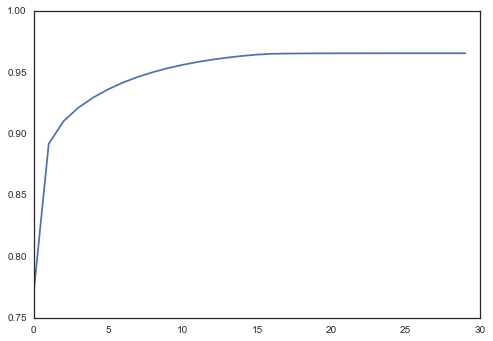

In [108]:
# まじか
plt.plot(weighted_sum_list)

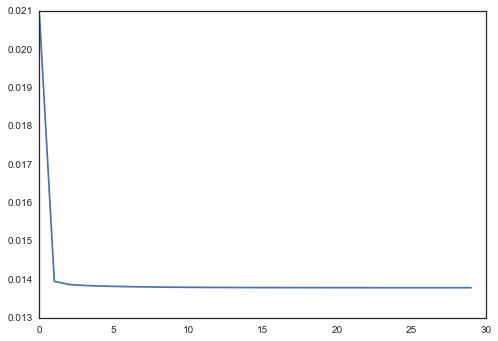

In [109]:
plt.plot(training_MSE_array)

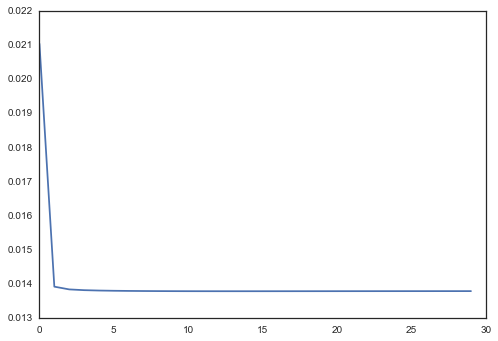

In [110]:
plt.plot(test_MSE_array)

In [50]:
import cond_num_dnn_ex
reload(cond_num_dnn_ex)

<module 'cond_num_dnn_ex' from 'cond_num_dnn_ex.pyc'>

In [51]:
feature_list =[m_feature_t1, m_feature_t12, m_feature_t36]
GT_list = [m_GT_t1, m_GT_t12, m_GT_t36]
epoch_list = [2160, 180, 60]
lr_list = [0.0005, 0.0005, 0.0005]

In [52]:
feature_list[0].shape

(13857, 12, 2)

In [53]:
results = cond_num_dnn_ex.cond_num_dnn_ex(vnn, param_list, feature_list, GT_list, 
                                          lr_list, epoch_list, featureImg_list)

0 0.0440386759411
144 0.0139203655737
288 0.013887130372
432 0.013879109063
576 0.0138760821838
720 0.0138758275238
864 0.0138771394563
1008 0.0138792025464
1152 0.0138815072401
1296 0.0138837641049
1440 0.0138858268288
1584 0.0138876355775
1728 0.0138891794854
1872 0.0138904733096
2016 0.0138915435445
0 0.0241043244105
12 0.0139659377992
24 0.013893282566
36 0.0138704988277
48 0.0138588205535
60 0.013852008388
72 0.01384793995
84 0.0138455742756
96 0.0138442992585
108 0.0138437234813
120 0.0138435881425
132 0.0138437206368
144 0.0138440063151
156 0.0138443699562
168 0.013844763192
0 0.0151531863994
4 0.0140237849208
8 0.0139828277022
12 0.0139666676323
16 0.01395828103
20 0.0139537630477
24 0.0139514271624
28 0.0139503514024
32 0.0139499918772
36 0.0139500226454
40 0.0139502498568
44 0.0139505605715
48 0.013950891203
52 0.0139512079208
56 0.013951494512


In [56]:
train_error_list, test_error_list, cn11236, det11236, wsc11236, gt1img360_list, gt1img120_list = results

In [57]:
namelist = ["train_error_list", "test_error_list", "cn11236", "det11236", "wsc11236", "gt1img360_list", "gt1img120_list"]
for data, name in zip(results, namelist):
    with gzip.open("../results/CondNumVLR/"+name+".npy.gz", "w") as f:
        np.save(f, data)

In [147]:
with gzip.open("../results/CondNumVLR/gt1img360_list.npy.gz", "r") as f:
    gt1img360_list = np.load(f)
with gzip.open("../results/CondNumVLR/gt1img120_list.npy.gz", "r") as f:
    gt1img120_list = np.load(f)

In [5]:
with gzip.open("../results/CondNumVLR/cn11236.npy.gz", "r") as f:
    cn11236 = np.load(f)
    
with gzip.open("../results/CondNumVLR/det11236.npy.gz", "r") as f:
    det11236 = np.load(f)

In [149]:
gt1img120_list.shape

(3, 2, 256, 256)

In [150]:
sio.savemat('../results/CondNumVLR/v_train360_list.mat', {'v_train360_list': gt1img360_list})
sio.savemat('../results/CondNumVLR/v_train120_list.mat', {'v_train120_list': gt1img120_list})

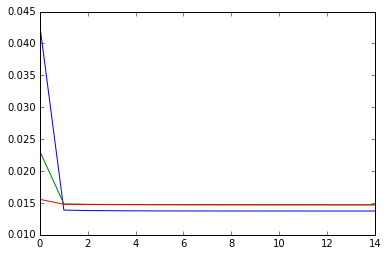

In [58]:
for i in range(3):    
    plt.plot(train_error_list[i])

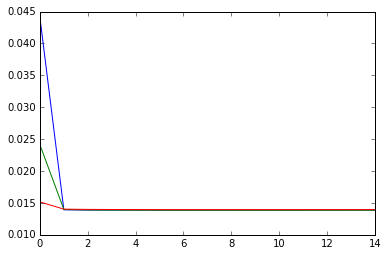

In [59]:
for i in range(3): 
    plt.plot(test_error_list[i])

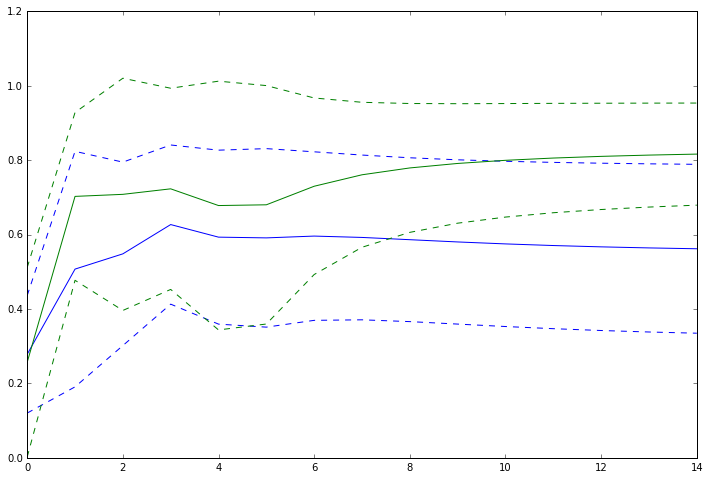

In [60]:
plt.figure(figsize=(12, 8))
color_list = ["b", "g", "r"]
for i in [0, 1]:
    mean = np.mean(cn11236[i], axis=1)
    std = np.std(cn11236[i], axis=1)
    x = np.arange(mean.shape[0])
    plt.plot(x, mean, color_list[i])
    plt.plot(x, mean - std, color_list[i]+"--")
    plt.plot(x, mean + std, color_list[i]+"--")

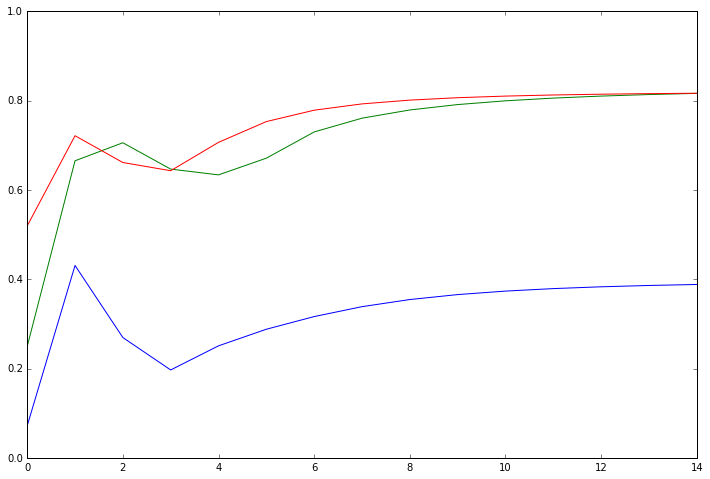

In [61]:
plt.figure(figsize=(12, 8))
color_list = ["b", "g", "r"]
for i in [0, 1, 2]:
    y = np.asarray(cn11236[i]) * np.sign(det11236[i])
    mean = np.mean(y, axis=1)
    std = np.std(y, axis=1)
    x = np.arange(mean.shape[0])
    plt.plot(x, mean, color_list[i])
    plt.ylim(0., 1.)

In [84]:
import seaborn as sb
sb.set_style("whitegrid")

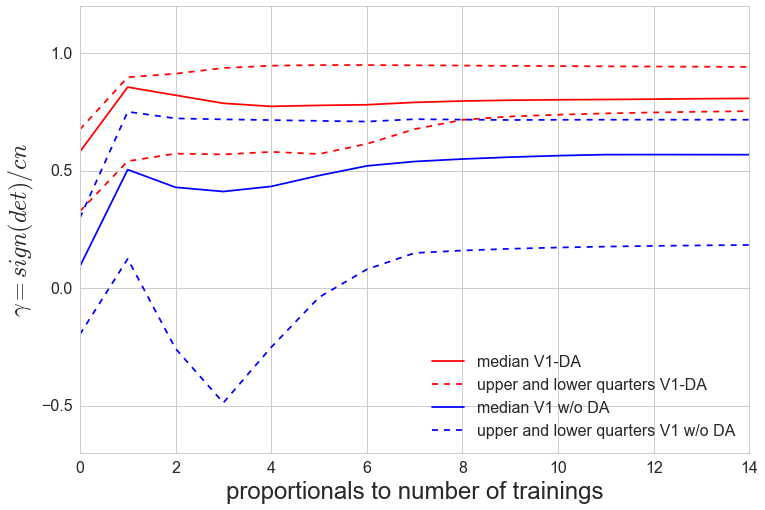

In [8]:
plt.figure(figsize=(12, 8))
color_list = ["b", "g", "r"]
DA = ["V1 w/o DA","", "V1-DA"]
for i in [2, 0]:
    y = np.asarray(cn11236[i]) * np.sign(det11236[i])
    mean = np.median(y, axis=1)
    upper_lowwer = np.percentile(y, [75, 25], axis=1)
    x = np.arange(mean.shape[0])
    plt.plot(x, mean, color_list[i], label="median "+DA[i])
    plt.plot(x, upper_lowwer[0], color_list[i]+"--", label="upper and lower quarters "+DA[i])
    plt.plot(x, upper_lowwer[1], color_list[i]+"--")
    plt.ylim(-0.8, 1.2)

plt.xlabel("proportionals to number of trainings", fontsize=24)
plt.xticks(fontsize=16)
plt.ylim(-0.7, 1.2)
plt.yticks(fontsize=16)
plt.ylabel(r"$\gamma=sign(det)/cn$", fontsize=24)
plt.legend(loc="lower right", fontsize=16)
plt.savefig('../figures/cn_inv.png', bbox_inches='tight')

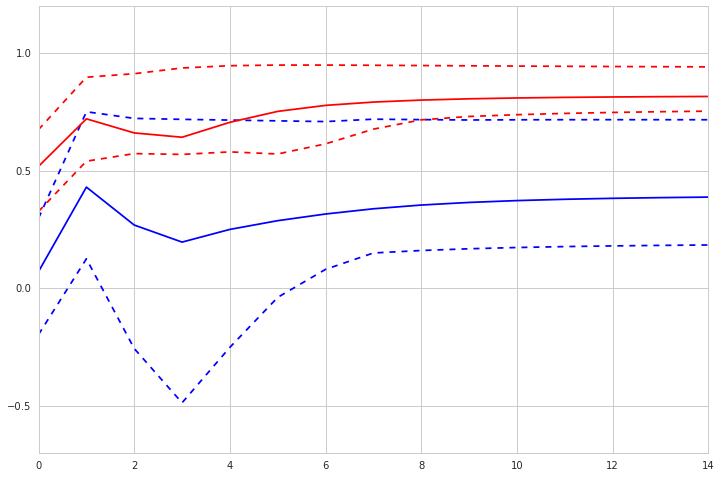

In [134]:
plt.figure(figsize=(12, 8))
color_list = ["b", "g", "r"]
for i in [0, 2]:
    y = np.asarray(cn11236[i]) * np.sign(det11236[i])
    mean = np.mean(y, axis=1)
    upper_lowwer = np.percentile(y, [75, 25], axis=1)
    x = np.arange(mean.shape[0])
    plt.plot(x, mean, color_list[i])
    plt.plot(x, upper_lowwer[0], color_list[i]+"--")
    plt.plot(x, upper_lowwer[1], color_list[i]+"--")
    plt.ylim(-0.7, 1.2)

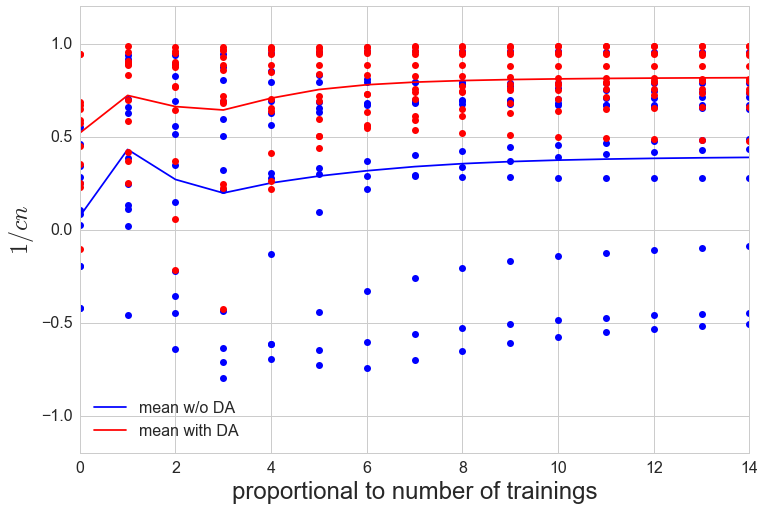

In [122]:
plt.figure(figsize=(12, 8))
color_list = ["b", "g", "r"]
DA = ["w/o DA","", "with DA"]
for i in [0, 2]:
    y = np.asarray(cn11236[i]) * np.sign(det11236[i])
    mean = np.mean(y, axis=1)
    x = np.arange(mean.shape[0])
    plt.plot(x, mean, color_list[i], label="mean "+DA[i])
    plt.plot(x, y, color_list[i]+"o")
    plt.xticks(fontsize=16)
    plt.xlabel("proportional to number of trainings", fontsize=24)
    plt.ylim(-1.2, 1.2)
    plt.yticks(fontsize=16)
    plt.ylabel(r"$1/cn$", fontsize=24)
plt.legend(loc="lower left", fontsize=16)
plt.savefig('../figures/cn_inv.png', bbox_inches='tight')

In [50]:
np.percentile(y, [75, 25])

array([ 0.95530079,  0.67926931])

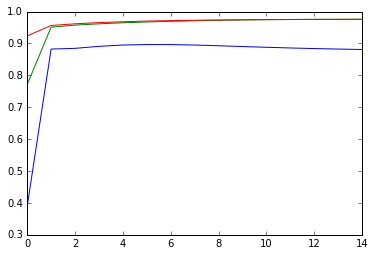

In [39]:
for i in range(3):
    plt.plot(wsc11236[i])

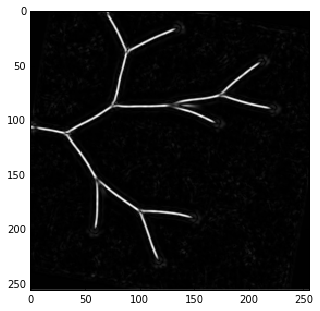

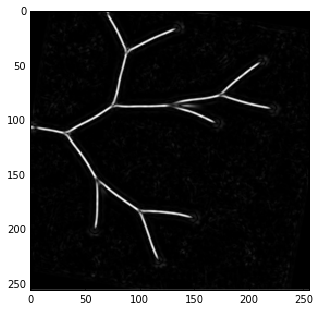

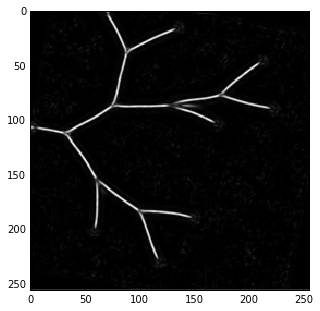

In [40]:
for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.linalg.norm(gt1img360_list[i], axis=0))

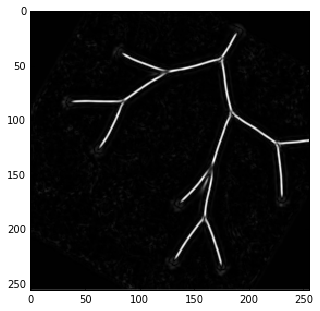

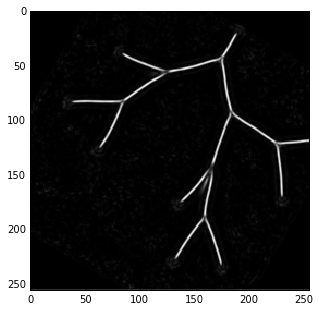

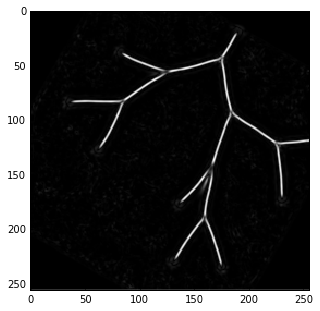

In [41]:
for i in range(3):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.linalg.norm(gt1img120_list[i], axis=0))